In [2]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from minisom import MiniSom
from sklearn.preprocessing import LabelEncoder
from pylab import bone, pcolor, colorbar, plot, show
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import numpy as np

<h1>1. Выбрать набор данных с размеченными объектами, который ранее использовался в
той или иной работе курса.
Построить диаграмму распределения объектов по классам. В случае
необходимости провести предобработку.</h1>

In [3]:
data = pd.read_csv('Emotion_classify_Data.csv')

data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5937 entries, 0 to 5936
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Comment  5937 non-null   object
 1   Emotion  5937 non-null   object
dtypes: object(2)
memory usage: 92.9+ KB


(                                             Comment Emotion
 0  i seriously hate one subject to death but now ...    fear
 1                 im so full of life i feel appalled   anger
 2  i sit here to write i start to dig out my feel...    fear
 3  ive been really angry with r and i feel like a...     joy
 4  i feel suspicious if there is no one outside l...    fear,
 None)

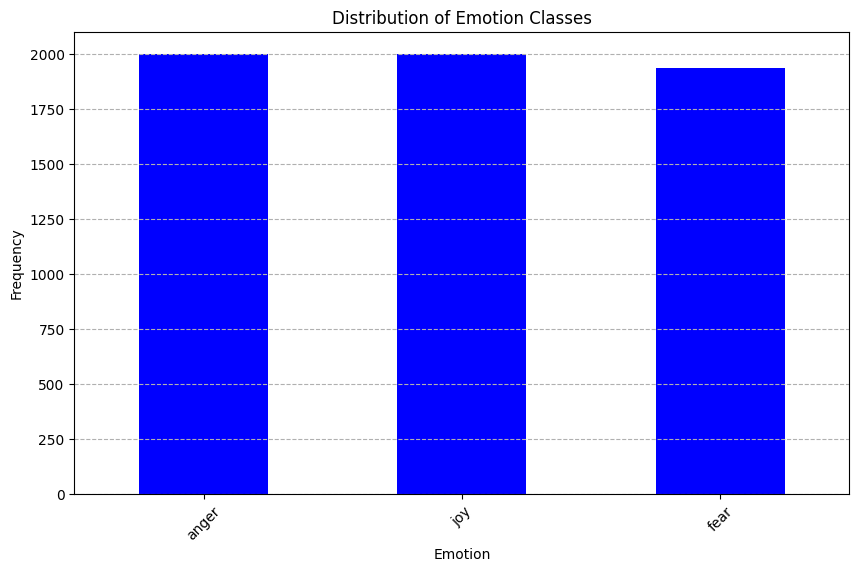

In [4]:
import matplotlib.pyplot as plt

emotion_counts = data['Emotion'].value_counts()

plt.figure(figsize=(10, 6))
emotion_counts.plot(kind='bar', color='blue')
plt.title('Distribution of Emotion Classes')
plt.xlabel('Emotion')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--')
plt.show()

<h1>2. Алгоритм самоорганизующихся карт Кохонена (рекомендуется использовать пакет
minisom).<br>
Построить модель Кохонена и разные варианты визуализации карты:<br>
- распределение объектов по ячейкам карты;<br>
- распределение объектов по классам для каждой ячейки<br>
Сравнить объекты двух ячеек карты по средним значениям показателей.</h1>

In [5]:
tfidf_vectorizer = TfidfVectorizer(max_features=100)

tfidf_features = tfidf_vectorizer.fit_transform(data['Comment'])

scaler = MinMaxScaler()
tfidf_features_scaled = scaler.fit_transform(tfidf_features.toarray())
tfidf_features_scaled.shape

(5937, 100)

In [6]:
label_encoder = LabelEncoder()

labels = label_encoder.fit_transform(data['Emotion'])
class_names = label_encoder.classes_

In [7]:
def create_and_show_som(x, y, s, lr, labels, pca_init = False):
    som = MiniSom(x=x, y=y, input_len=100, sigma=s, learning_rate=lr)
    if pca_init:
        som.pca_weights_init(tfidf_features_scaled)
    else:
        som.random_weights_init(tfidf_features_scaled)
    som.train_random(data=tfidf_features_scaled, num_iteration=100)

    plt.figure(figsize=(10, 10))
    plt.pcolor(som.distance_map().T, cmap='bone_r')  # distance_map() returns the U-Matrix
    plt.colorbar()
    plt.show()


    plt.figure(figsize=(10, 10))
    bone()
    pcolor(som.distance_map().T, cmap='bone_r')
    colorbar()

    markers = ['o', 's', 'D']
    colors = ['r', 'g', 'b']

    for cnt, xx in enumerate(tfidf_features_scaled):
        w = som.winner(xx) 
        class_idx = labels[cnt]
        plt.plot(w[0] + 0.5, w[1] + 0.5, markers[class_idx], markeredgecolor=colors[class_idx],
                markerfacecolor='None', markersize=10, markeredgewidth=2,
                label=class_names[class_idx])

    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = dict(zip(labels, handles)) 
    plt.legend(by_label.values(), by_label.keys())

    plt.show()

    return som

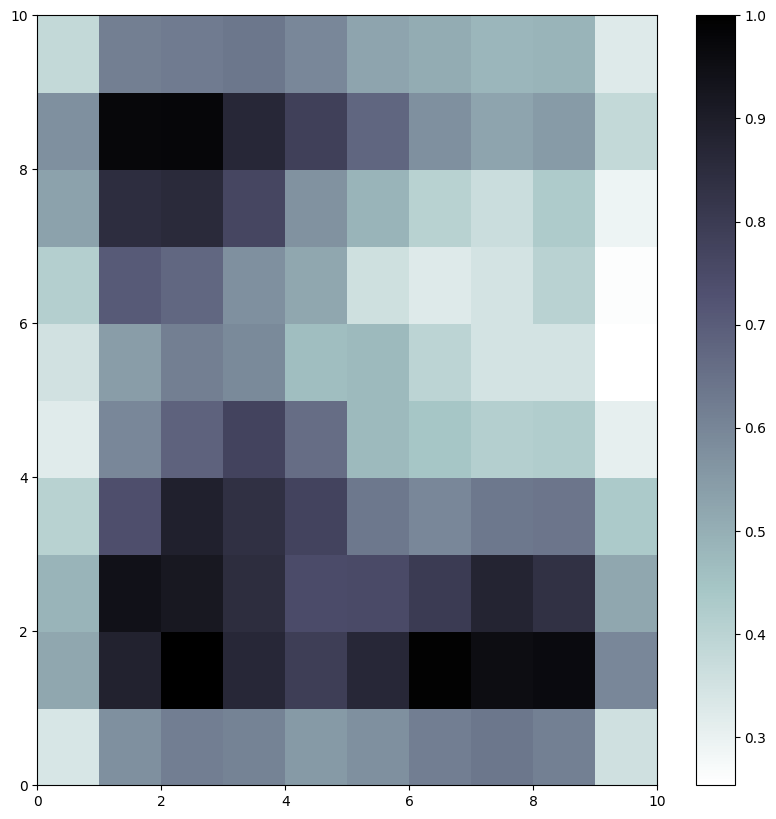

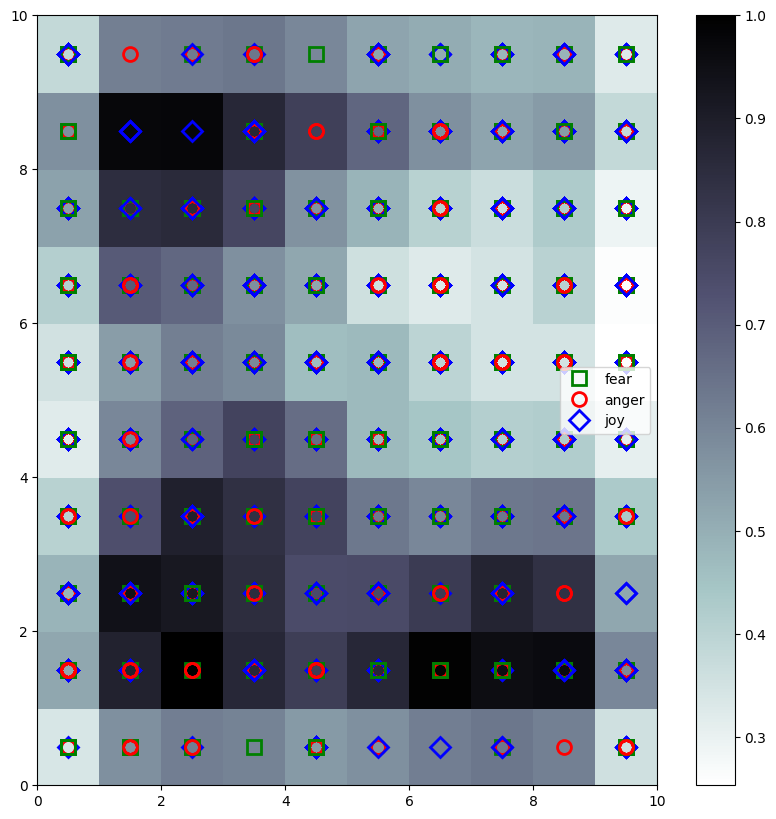

In [8]:
som = create_and_show_som(10, 10, 1, .5, labels)

In [25]:
cell_1 = (0, 0)
cell_2 = (3, 1)

objects_cell_1 = []
objects_cell_2 = []

for i, x in enumerate(tfidf_features_scaled):
    winner = som.winner(x)
    if winner == cell_1:
        objects_cell_1.append(x)
    elif winner == cell_2:
        objects_cell_2.append(x)

objects_cell_1 = np.array(objects_cell_1)
objects_cell_2 = np.array(objects_cell_2)

avg_features_cell_1 = np.mean(objects_cell_1, axis=0)
avg_features_cell_2 = np.mean(objects_cell_2, axis=0)

feature_differences = avg_features_cell_1 - avg_features_cell_2

overall_difference = np.linalg.norm(avg_features_cell_1 - avg_features_cell_2)

print("Average features for Cell 1:", avg_features_cell_1)
print("Average features for Cell 2:", avg_features_cell_2)
print("Feature differences:", feature_differences)
print("Overall difference:", overall_difference)

Average features for Cell 1: [0.         0.         0.20273703 0.         0.07796641 0.
 0.         0.         0.         0.         0.09376836 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.0818165  0.07392896 0.0380157  0.         0.         0.
 0.         0.50934515 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.06103977 0.         0.
 0.         0.         0.         0.         0.08621213 0.
 0.1157416  0.         0.         0.24774943 0.         0.
 0.         0.         0.         0.14202765 0.         0.15659817
 0.         0.         0.         0.         0.         0.21663018
 0.         0.         0.         0.         0.03127309 0.02653544
 0.         0.         0.         0.         0.         0.0390179
 0.         0.22382663 0.         0.         0.         0.
 0.3616597  0.         0.         0.         0.        

<h1>3. Алгоритм t-SNE.
Выполнить преобразование данных в двумерное пространство с помощью
алгоритма t-SNE и отобразить распределение объектов (цвет соответствует классу
объекта).</h1>

In [10]:
tsne_model = TSNE(n_components=2, random_state=42)
tsne_features = tsne_model.fit_transform(tfidf_features_scaled)
tsne_features

array([[25.28649  , 29.925371 ],
       [51.58569  , 21.068207 ],
       [28.223541 ,  8.715126 ],
       ...,
       [29.96437  ,  4.0791264],
       [46.281002 , -1.5118934],
       [32.95424  , -4.1713943]], dtype=float32)

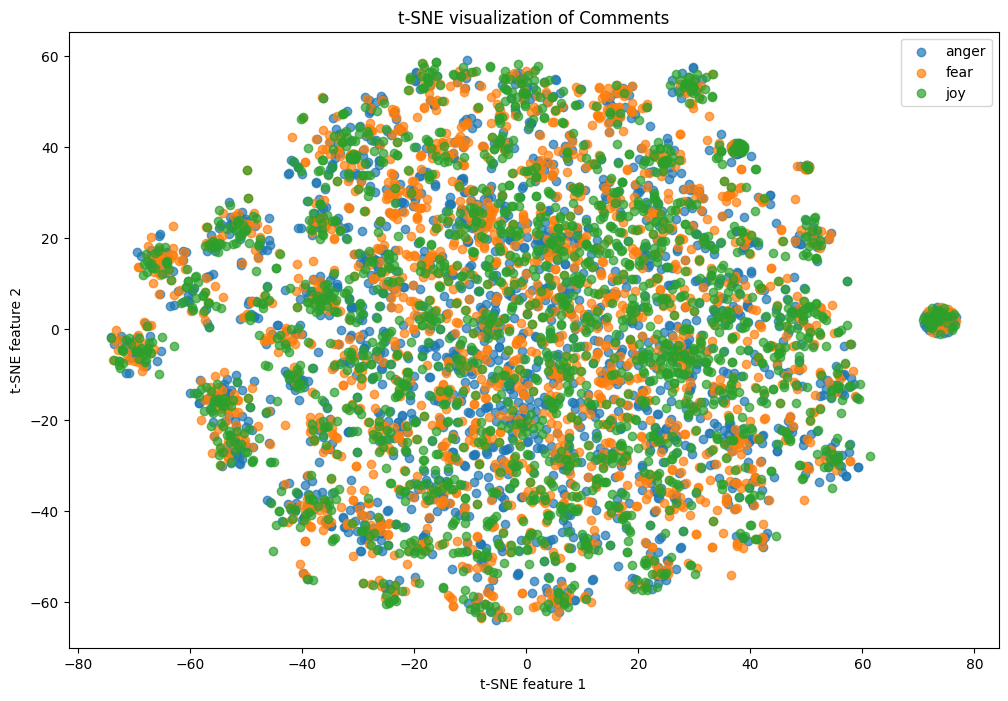

In [12]:
plt.figure(figsize=(12, 8))

for class_name in label_encoder.classes_:
    idxs = data[data.Emotion == class_name].index
    plt.scatter(tsne_features[idxs, 0], tsne_features[idxs, 1], label=class_name, alpha=0.7)

plt.title('t-SNE visualization of Comments')
plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.legend()
plt.show()

In [13]:
print(f"Вариант {1 + (ord('G') + ord('F')) % 4}")

Вариант 2


<h1>4. Сопоставление результатов кластеризации kMeans и SOM<br>
Проведите кластеризацию алгоритмом kMeans, где параметр k равен числу ячеек
карты SOM.<br>
Вычислите оценку согласованности кластерных решений Rand для kMeans и SOM.<br>
Проведите эксперименты с разными установками для SOM (параметры карты,
инициализация).<br></h1>

In [14]:
num_clusters = 100
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_clusters = kmeans.fit_predict(tfidf_features_scaled)

c:\Users\79270\Desktop\Zubr\enviroments\ml\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [15]:
def get_rand_score(som):
    bmus = [som.winner(x) for x in tfidf_features_scaled]
    som_clusters = [x * som.get_weights().shape[0] + y for x, y in bmus]
    rand_index = adjusted_rand_score(som_clusters, kmeans_clusters)
    print(rand_index)

In [16]:
get_rand_score(som)

0.1990418774777988


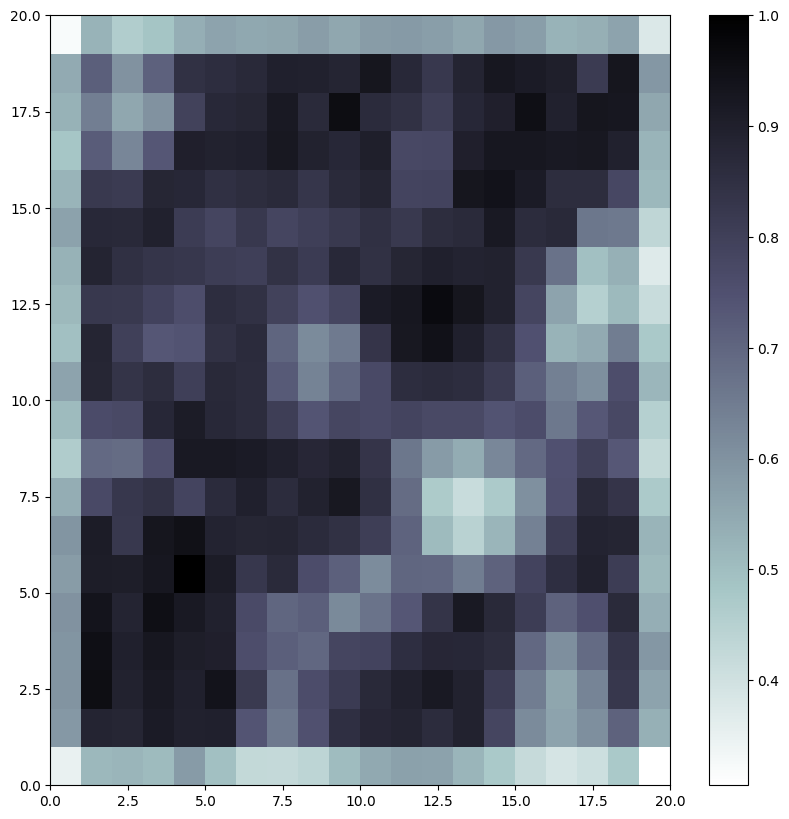

c:\Users\79270\Desktop\Zubr\enviroments\ml\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


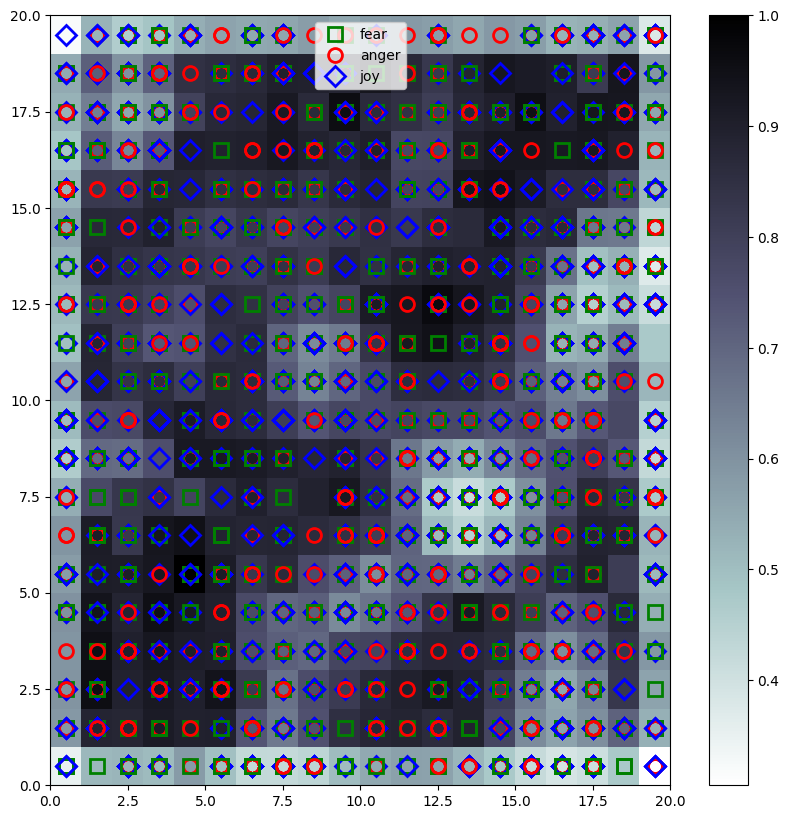

In [17]:
som2 = create_and_show_som(x=20, y=20, s=1, lr=0.5, labels=labels)

In [18]:
get_rand_score(som2)

0.23766183390581605


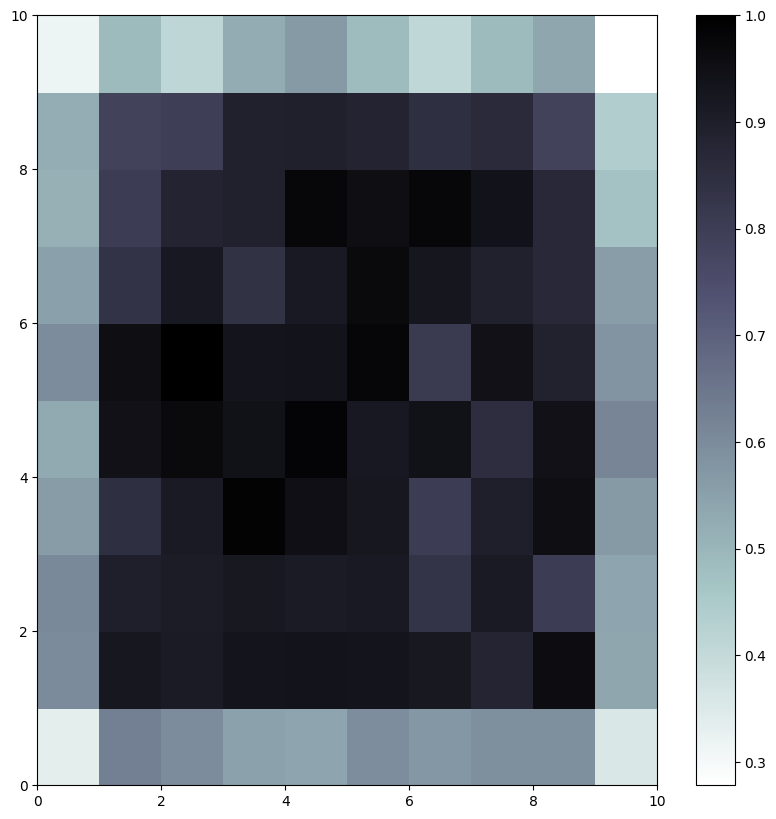

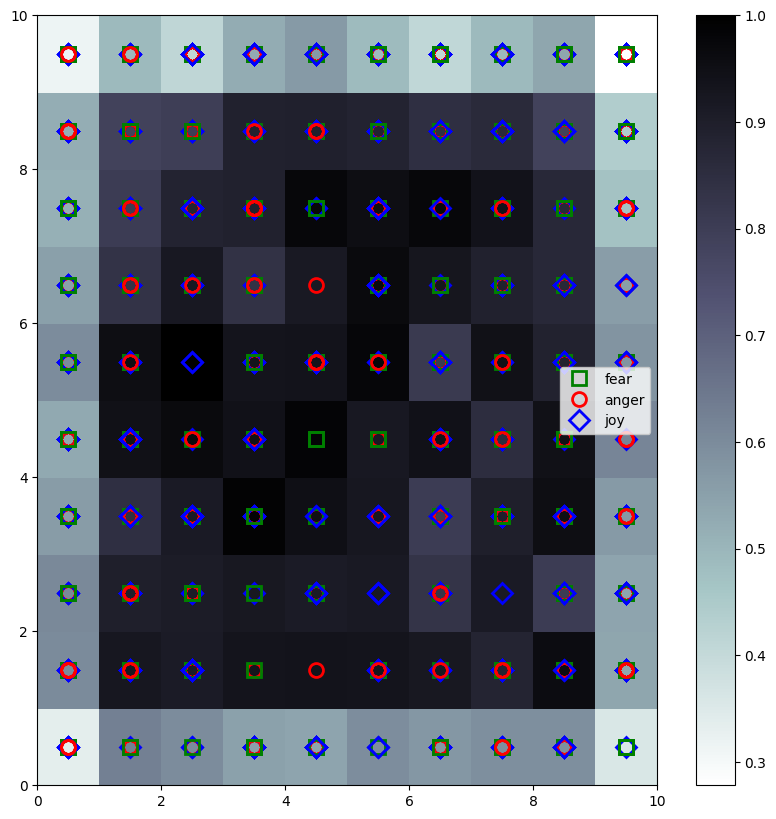

0.054726542953934004


In [19]:
som3 = create_and_show_som(x=10, y=10, s=.5, lr=0.5, labels=labels)
get_rand_score(som3)

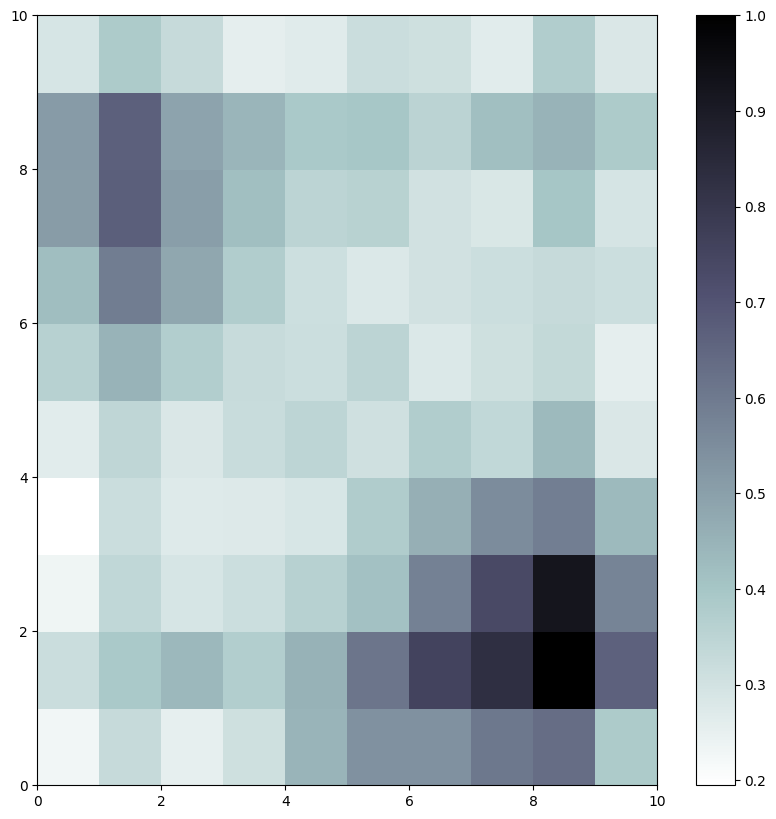

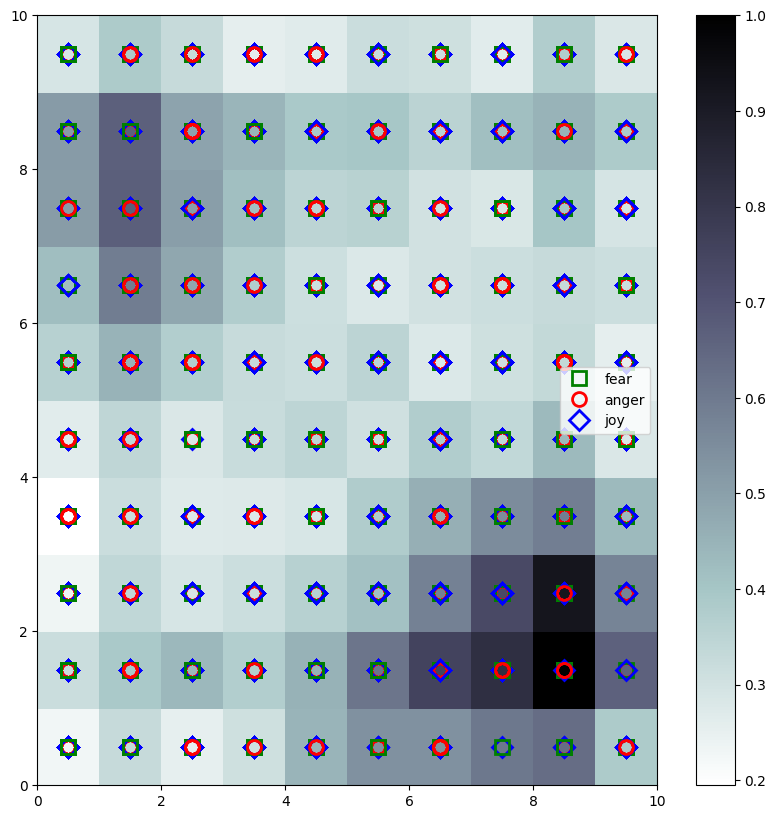

0.20099884117893


In [20]:
som4 = create_and_show_som(x=10, y=10, s=1.5, lr=0.5, labels=labels)
get_rand_score(som4)

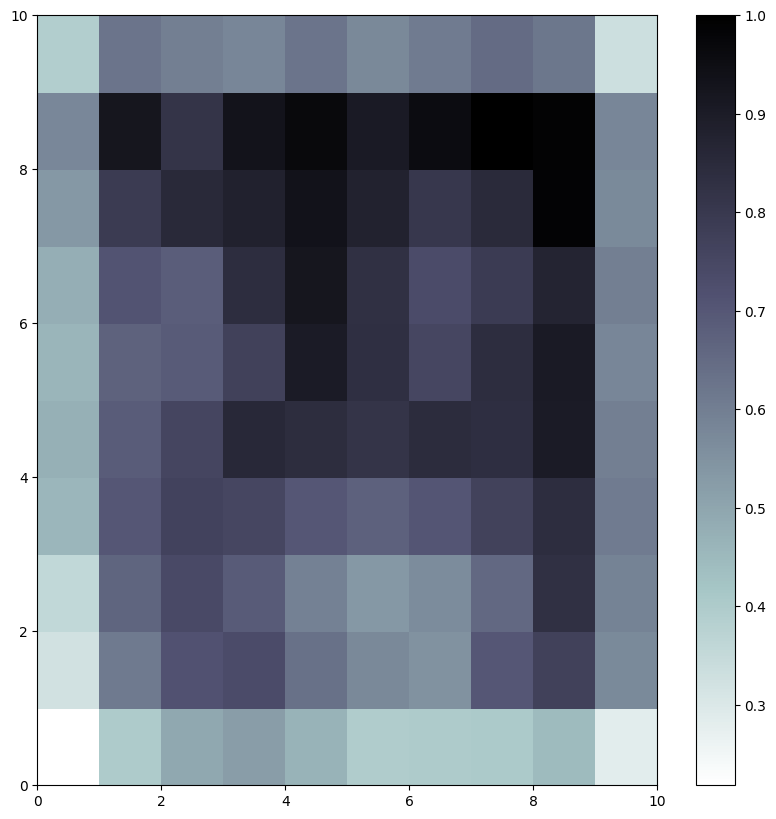

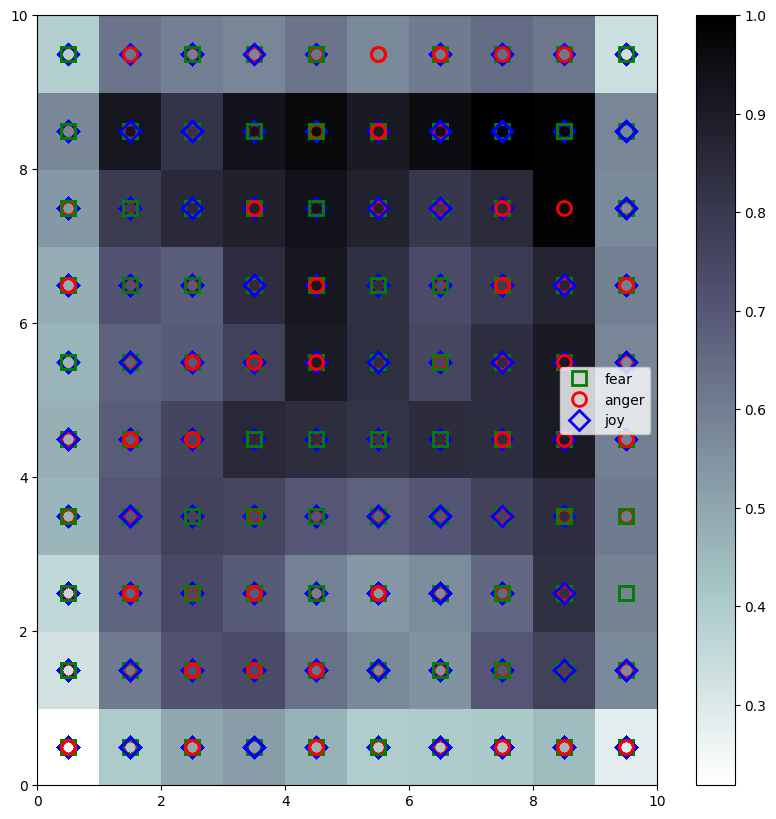

0.12420378596613257


In [21]:
som4 = create_and_show_som(x=10, y=10, s=1, lr=0.2, labels=labels)
get_rand_score(som4)

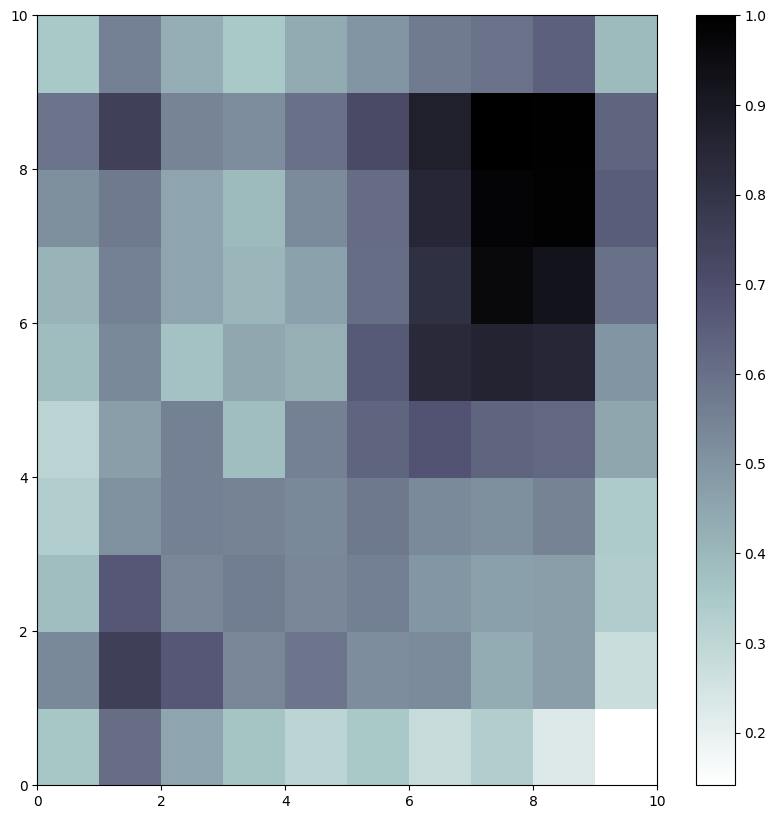

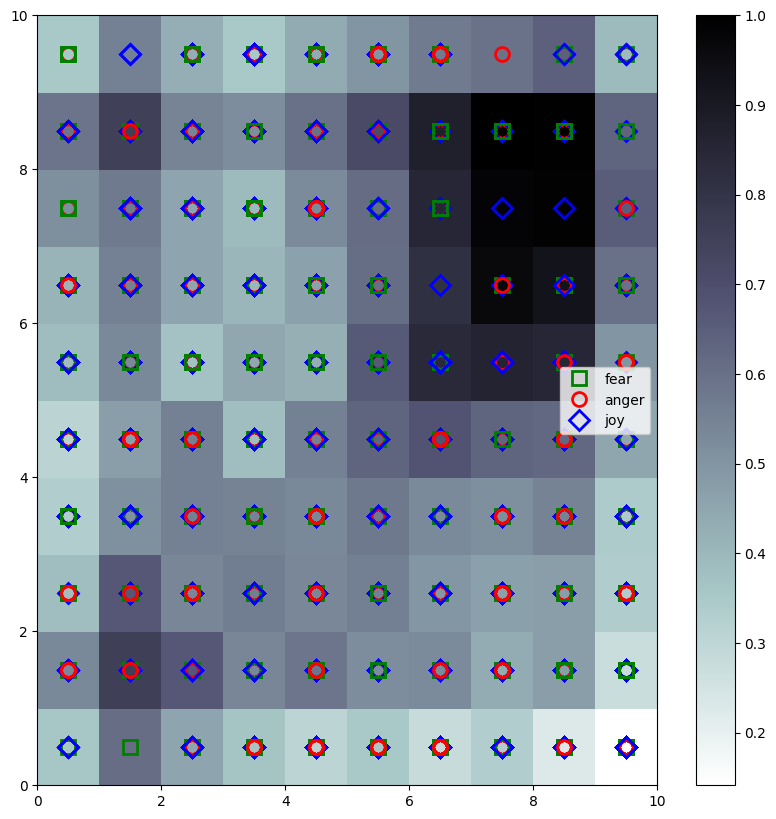

0.2131805203551077


In [22]:
som5 = create_and_show_som(x=10, y=10, s=1, lr=0.9, labels=labels)
get_rand_score(som5)

c:\Users\79270\Desktop\Zubr\enviroments\ml\Lib\site-packages\minisom.py:388: ComplexWarning: Casting complex values to real discards the imaginary part
  self._weights[i, j] = c1*pc[pc_order[0]] + \


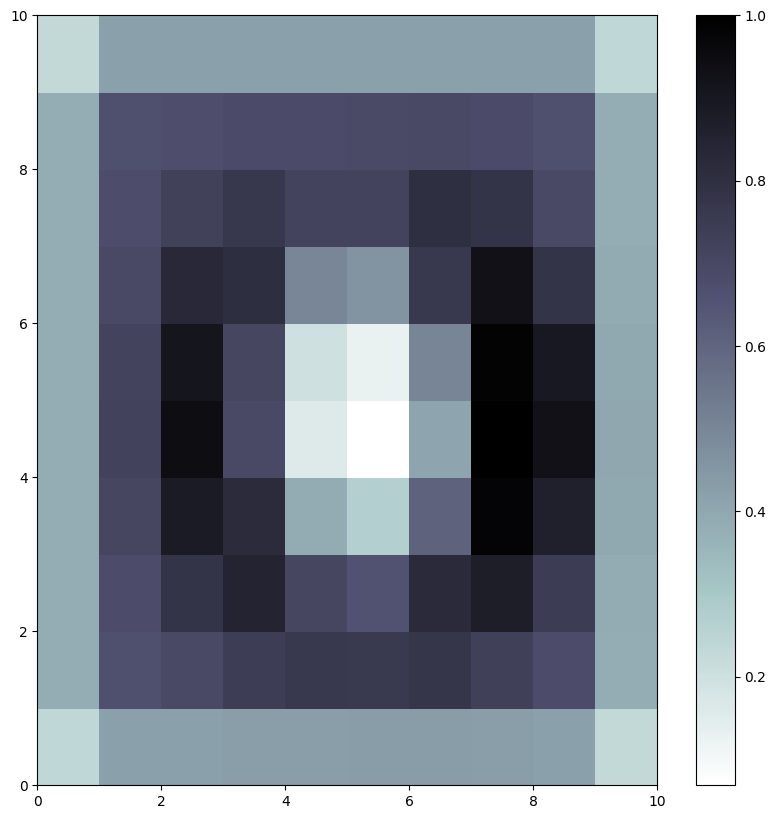

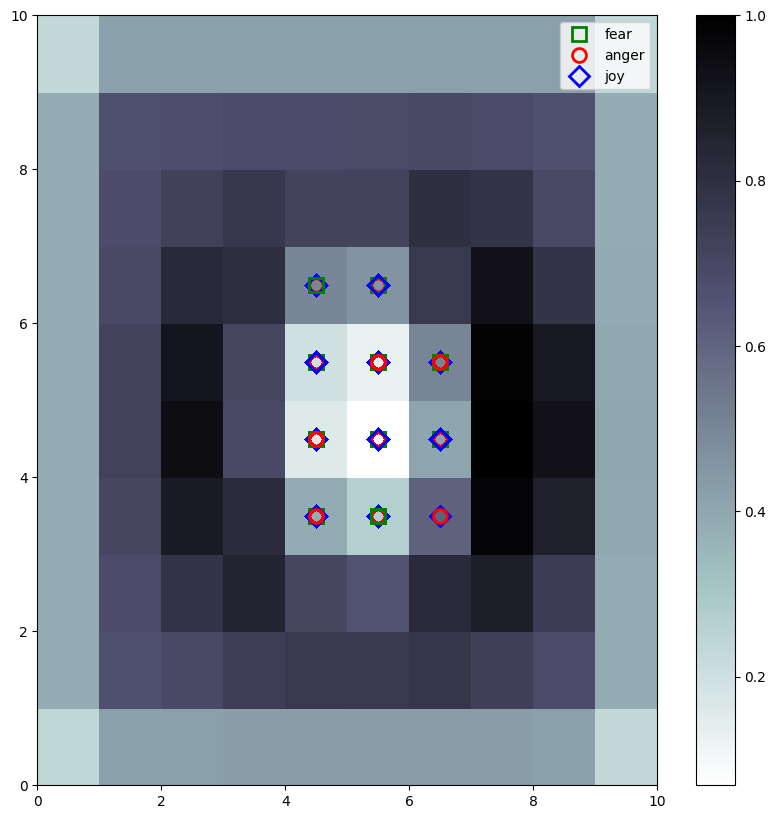

0.038251569720925645


In [23]:
som6 = create_and_show_som(x=10, y=10, s=1, lr=0.5, labels=labels, pca_init=True)
get_rand_score(som6)